In [1]:
import pandas as pd
import numpy as np
import joblib
import os
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1. Load Data
df = pd.read_csv("D:/1.UNI 5th Semester/6. Advance DataBase/ADVANCE_DB PROJECT/ds_project/mellyapp/ml/mellyapp_dataset_OLAP.csv")

# 2. Drop non-numeric/categorical ID columns
df = df.drop(['stu_id', 'course_id'], axis=1)

# 3. Feature Engineering (Optional)
df['avg_duration_per_activity'] = df['total_duration_minutes'] / df['total_activities']
df['assignment_total'] = df['individual_assignment_count'] + df['group_assignment_count']

# 4. Handle NaN or infinite values from division
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# 5. Split features & target
X = df.drop('grade', axis=1)
y = df['grade']

# 6. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 7. Pipeline + Model
pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('model', XGBRegressor(objective='reg:squarederror', random_state=42))
])

# 8. Hyperparameter Grid
param_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [3, 5],
    'model__learning_rate': [0.01, 0.1],
    'model__subsample': [0.8, 1.0],
    'model__colsample_bytree': [0.8, 1.0],
}

grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, scoring='r2', verbose=2, n_jobs=-1)

# 9. Fit Model
grid.fit(X_train, y_train)

# 10. Evaluation
y_pred = grid.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Best Params: {grid.best_params_}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.4f}")

# 11. Feature Importance
final_model = grid.best_estimator_.named_steps['model']
importances = final_model.feature_importances_
feature_names = X.columns

print("\nFeature Importance:")
for name, score in sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True):
    print(f"{name}: {score:.4f}")



Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best Params: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.01, 'model__max_depth': 3, 'model__n_estimators': 100, 'model__subsample': 0.8}
RMSE: 15.08
MAE: 13.09
R²: -0.0165

Feature Importance:
avg_duration_per_activity: 0.1270
gender: 0.1156
total_activities: 0.1144
forum_count: 0.1133
total_duration_minutes: 0.1044
assignment_total: 0.0961
age: 0.0878
group_assignment_count: 0.0877
individual_assignment_count: 0.0849
quiz_count: 0.0688


d:\ANACONDA 2\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from xgboost import XGBClassifier

# ---------------------- Load & Preprocessing ----------------------

df = pd.read_csv("D:/1.UNI 5th Semester/6. Advance DataBase/ADVANCE_DB PROJECT/ds_project/mellyapp/ml/mellyapp_dataset_OLAP.csv")

def convert_grade(grade):
    if grade >= 85:
        return 'A'
    elif grade >= 70:
        return 'B'
    elif grade >= 55:
        return 'C'
    elif grade >= 40:
        return 'D'
    else:
        return 'F'

df['grade_class'] = df['grade'].apply(convert_grade)

X = df.drop(['grade', 'grade_class'], axis=1)
y = df['grade_class']

# Encode label ke angka
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# ---------------------- Split Data ----------------------

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# ---------------------- ML Pipeline ----------------------

pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('model', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42))
])

param_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [3, 5],
    'model__learning_rate': [0.01, 0.1],
    'model__subsample': [0.8],
    'model__colsample_bytree': [0.8]
}

grid = GridSearchCV(pipeline, param_grid=param_grid, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)

# ---------------------- Evaluation ----------------------

y_pred = grid.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Best Params: {grid.best_params_}")
print(f"Accuracy: {acc:.4f}")

print("\nClassification Report:\n", classification_report(le.inverse_transform(y_test), le.inverse_transform(y_pred)))

cm = confusion_matrix(le.inverse_transform(y_test), le.inverse_transform(y_pred), labels=['A', 'B', 'C', 'D', 'F'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['A', 'B', 'C', 'D', 'F'], yticklabels=['A', 'B', 'C', 'D', 'F'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig("confusion_matrix.png")
plt.close()


d:\ANACONDA 2\Lib\site-packages\xgboost\training.py:183: UserWarning: [07:36:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
d:\ANACONDA 2\Lib\site-packages\xgboost\training.py:183: UserWarning: [07:36:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
d:\ANACONDA 2\Lib\site-packages\xgboost\training.py:183: UserWarning: [07:36:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
d:\ANACONDA 2\Lib\site-packages\xgboost\training.py:183: UserWarning: [07:36:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
d:\ANACONDA 2\Li

Best Params: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.01, 'model__max_depth': 3, 'model__n_estimators': 100, 'model__subsample': 0.8}
Accuracy: 0.2500

Classification Report:
               precision    recall  f1-score   support

           A       0.23      0.30      0.26        30
           B       0.33      0.32      0.33        28
           C       0.20      0.21      0.21        28
           D       0.00      0.00      0.00        10

    accuracy                           0.25        96
   macro avg       0.19      0.21      0.20        96
weighted avg       0.23      0.25      0.24        96



KeyError: 'individual_assignment'

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier

# 1. Load data
df = pd.read_csv("D:/1.UNI 5th Semester/6. Advance DataBase/ADVANCE_DB PROJECT/ds_project/mellyapp/ml/melly_dataset_Clasify_OLAP.csv")

# 2. Handle missing values (isi 0 untuk aktivitas)
activity_cols = ['quiz_count', 'forum_count', 'assignment_count', 'total_activities', 'total_duration', 'activity_density']
df[activity_cols] = df[activity_cols].fillna(0)

# 3. Fitur dan target
X = df[['gender', 'age'] + activity_cols]
y = df['grade']  # klasifikasi grade

# 4. Preprocessing
numeric_features = ['age'] + activity_cols
categorical_features = ['gender']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ])

# 5. Model pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# 6. Hyperparameter tuning
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [5, 10, None],
    'classifier__min_samples_split': [2, 5],
}

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

# 7. Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 8. Train
grid_search.fit(X_train, y_train)

# 9. Evaluate
y_pred = grid_search.predict(X_test)

print("Best Parameters:", grid_search.best_params_)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Fitting 5 folds for each of 12 candidates, totalling 60 fits


d:\ANACONDA 2\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Best Parameters: {'classifier__max_depth': None, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}

Classification Report:
              precision    recall  f1-score   support

          50       0.00      0.00      0.00         1
          51       0.00      0.00      0.00         2
          52       0.00      0.00      0.00         4
          53       0.00      0.00      0.00         2
          54       0.00      0.00      0.00         2
          55       0.00      0.00      0.00         2
          56       0.00      0.00      0.00         1
          57       0.00      0.00      0.00         3
          58       0.00      0.00      0.00         1
          59       0.00      0.00      0.00         2
          60       0.00      0.00      0.00         2
          61       0.00      0.00      0.00         2
          62       0.00      0.00      0.00         4
          63       0.00      0.00      0.00         1
          64       0.00      0.00      0.00    

d:\ANACONDA 2\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\ANACONDA 2\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\ANACONDA 2\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\ANACONDA 2\Lib\site-packages\sklearn\metrics\_classification.py:1531: Undefine

Best Parameters: {'regressor__max_depth': 10, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 100}
MAE: 13.94
RMSE: 16.37
R² Score: -0.23


d:\ANACONDA 2\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


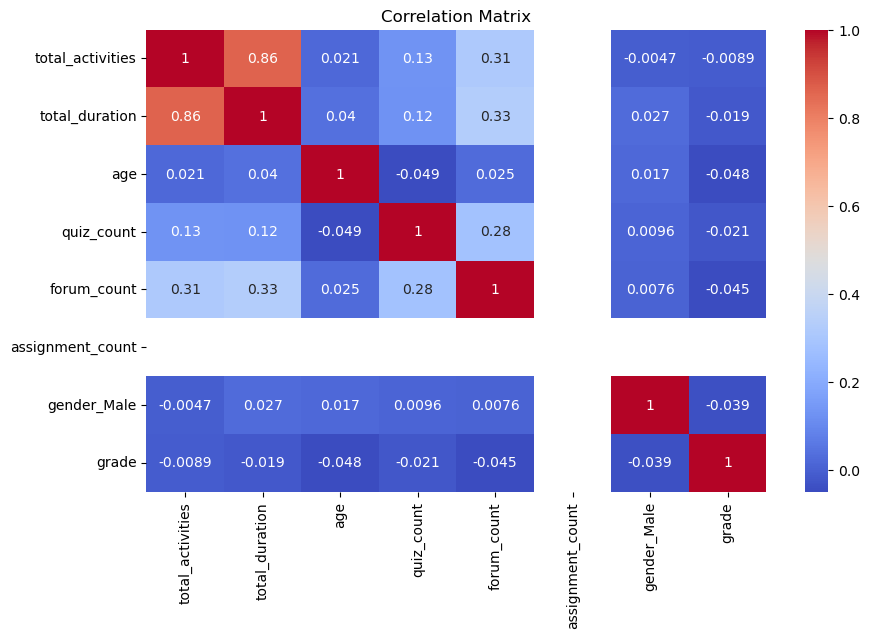

In [12]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib

# Load dataset
df = pd.read_csv('D:/1.UNI 5th Semester/6. Advance DataBase/ADVANCE_DB PROJECT/ds_project/mellyapp/ml/melly_dataset_Clasify_OLAP.csv')

# Fitur dan target
X = df[['total_activities', 'total_duration', 'gender', 'age', 'quiz_count', 'forum_count', 'assignment_count']]
y = df['grade']

# One-hot encoding untuk gender (jika perlu)
X = pd.get_dummies(X, columns=['gender'], drop_first=True)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Hyperparameter tuning
param_grid = {
    'regressor__n_estimators': [50, 100],
    'regressor__max_depth': [None, 10, 20],
    'regressor__min_samples_split': [2, 5]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Model terbaik
best_model = grid_search.best_estimator_

# Simpan model
# joblib.dump(best_model, 'regression_model.pkl')

# Evaluasi model
y_pred = best_model.predict(X_test)
print(f"Best Parameters: {grid_search.best_params_}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"RMSE: {mean_squared_error(y_test, y_pred, squared=False):.2f}")
print(f"R² Score: {r2_score(y_test, y_pred):.2f}")

import seaborn as sns
import matplotlib.pyplot as plt

# Gabungkan kembali fitur dan target untuk cek korelasi
df_corr = X.copy()
df_corr['grade'] = y
plt.figure(figsize=(10, 6))
sns.heatmap(df_corr.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()


In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
import joblib

# Load dataset
df = pd.read_csv('D:/1.UNI 5th Semester/6. Advance DataBase/ADVANCE_DB PROJECT/ds_project/mellyapp/ml/melly_dataset_Clasify_OLAP.csv')

# Fitur dan target
X = df[['total_activities', 'total_duration', 'age', 'quiz_count', 'forum_count', 'assignment_count', 'gender']]
y = df['grade']

# One-hot encoding untuk gender
X = pd.get_dummies(X, columns=['gender'], drop_first=True)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('regressor', XGBRegressor(objective='reg:squarederror', random_state=42))
])

# Hyperparameter tuning
param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [3, 5, 7],
    'regressor__learning_rate': [0.01, 0.1],
    'regressor__subsample': [0.8, 1.0]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model
# best_model = grid_search.best_estimator_
# joblib.dump(best_model, 'xgboost_regressor_model.pkl')

# Evaluation
y_pred = best_model.predict(X_test)
print(f"Best Parameters: {grid_search.best_params_}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"RMSE: {mean_squared_error(y_test, y_pred, squared=False):.2f}")
print(f"R² Score: {r2_score(y_test, y_pred):.2f}")


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters: {'regressor__learning_rate': 0.01, 'regressor__max_depth': 3, 'regressor__n_estimators': 100, 'regressor__subsample': 1.0}
MAE: 13.94
RMSE: 16.37
R² Score: -0.23


d:\ANACONDA 2\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

# 1. Load Data
df = pd.read_csv('D:/1.UNI 5th Semester/6. Advance DataBase/ADVANCE_DB PROJECT/ds_project/mellyapp/ml/melly_dataset_Clasify_OLAP.csv')

# 2. Drop kolom ID / tidak relevan
df = df.drop(columns=['stu_id', 'course_id'])

# 3. Ubah grade ke kategori huruf
def grade_to_letter(grade):
    if grade >= 85:
        return 'A'
    elif grade >= 70:
        return 'B'
    elif grade >= 60:
        return 'C'
    else:
        return 'D'

df['grade_letter'] = df['grade'].apply(grade_to_letter)

# 3.5 Encode kolom gender
df['gender'] = df['gender'].map({'Male': 1, 'Female': 0})

# 4. Fitur dan target
X = df.drop(columns=['grade', 'grade_letter'])
y = df['grade_letter']

# Encode label target (A/B/C/D) jadi angka
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# 5. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

# 6. Pipeline dengan scaler + XGBoost Classifier
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42))
])

# 7. Train model
pipeline.fit(X_train, y_train)

# 8. Predict dan evaluasi
y_pred = pipeline.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# 9. Cross-Validation Accuracy
scores = cross_val_score(pipeline, X, y_encoded, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy (5-fold): {scores.mean():.2f}")


d:\ANACONDA 2\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:21:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Classification Report:
               precision    recall  f1-score   support

           A       0.37      0.42      0.39        31
           B       0.27      0.27      0.27        30
           C       0.36      0.24      0.29        21
           D       0.05      0.06      0.05        18

    accuracy                           0.27       100
   macro avg       0.26      0.24      0.25       100
weighted avg       0.28      0.27      0.27       100

Confusion Matrix:
 [[13 10  3  5]
 [ 9  8  4  9]
 [ 6  4  5  6]
 [ 7  8  2  1]]


d:\ANACONDA 2\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:21:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
d:\ANACONDA 2\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:21:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
d:\ANACONDA 2\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:21:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
d:\ANACONDA 2\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:21:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
d:\ANACONDA 2\Li

Cross-Validation Accuracy (5-fold): 0.25


In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# 1. Load data
df = pd.read_csv('D:/1.UNI 5th Semester/6. Advance DataBase/ADVANCE_DB PROJECT/ds_project/mellyapp/ml/melly_dataset_Clasify_OLAP.csv')

# 2. Drop kolom yang tidak relevan
df = df.drop(columns=['stu_id', 'course_id'])

# 3. Buat label 'dropout'
# Drop Out = grade < 60 ATAU aktivitas sangat rendah (< threshold)
activity_threshold = 10  # kamu bisa sesuaikan
df['dropout'] = df.apply(lambda row: 1 if (row['grade'] < 60 or row['total_activities_done'] < activity_threshold) else 0, axis=1)

# 4. Encode categorical (Gender, Activity Type)
for col in ['gender', 'activity_type']:
    if col in df.columns:
        df[col] = LabelEncoder().fit_transform(df[col])

# 5. Split fitur dan target
X = df.drop(columns=['grade', 'dropout'])
y = df['dropout']

# 6. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# 7. Pipeline + Model
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(random_state=42))
])

# 8. Train
pipeline.fit(X_train, y_train)

# 9. Evaluate
y_pred = pipeline.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# 10. Cross-validation score
scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy (5-fold): {scores.mean():.2f}")


KeyError: 'total_activities_done'

In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

# 1. Load dataset
df = pd.read_csv('D:/1.UNI 5th Semester/6. Advance DataBase/ADVANCE_DB PROJECT/ds_project/mellyapp/ml/dropout_dataset.csv')

# 2. Ubah gender menjadi numerik
df['gender'] = df['gender'].map({'Male': 0, 'Female': 1})

# 3. Pisahkan fitur dan target
X = df.drop(columns=['dropout'])  # fitur
y = df['dropout']                 # target dropout

# 4. Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 5. Buat pipeline model
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', XGBClassifier(random_state=42))
])

# 6. Training
pipeline.fit(X_train, y_train)

# 7. Evaluasi
y_pred = pipeline.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# 8. Cross-validation
scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy (5-fold): {scores.mean():.2f}")


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        79
           1       1.00      1.00      1.00        21

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100

Confusion Matrix:
 [[79  0]
 [ 0 21]]
Cross-Validation Accuracy (5-fold): 1.00


In [30]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

df = pd.read_csv('D:/1.UNI 5th Semester/6. Advance DataBase/ADVANCE_DB PROJECT/ds_project/mellyapp/ml/dropout_dataset.csv')

# 1. Fitur dan target
X = df.drop(columns=['dropout', 'grade'])  # Buang target dan grade
y = df['dropout']

# 2. Kolom kategorik dan numerik
categorical_features = ['gender']
numerical_features = ['age', 'total_activities_done', 'total_duration_minutes']

# 3. Preprocessor
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first'), categorical_features),
    ('num', StandardScaler(), numerical_features)
])

# 4. Pipeline
pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('clf', XGBClassifier(random_state=42))
])

# 5. Split dan training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
pipeline.fit(X_train, y_train)

# 6. Evaluasi
y_pred = pipeline.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# 7. Cross-validation
scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy (5-fold): {scores.mean():.2f}")


Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.92      0.87        79
           1       0.50      0.29      0.36        21

    accuracy                           0.79       100
   macro avg       0.66      0.60      0.62       100
weighted avg       0.76      0.79      0.77       100

Confusion Matrix:
 [[73  6]
 [15  6]]
Cross-Validation Accuracy (5-fold): 0.64


In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

# 1. Load dataset
df = pd.read_csv('D:/1.UNI 5th Semester/6. Advance DataBase/ADVANCE_DB PROJECT/ds_project/mellyapp/ml/melly_dataset_dropoutcsv.csv')  # atau path lokal kamu

# 2. Encode 'gender' jadi numerik
le = LabelEncoder()
df['gender'] = le.fit_transform(df['gender'])  # Male=1, Female=0 (misalnya)

# 3. Cek dan drop baris yang memiliki missing values jika ada
df = df.dropna()

# 4. Pisahkan fitur dan target
X = df.drop(columns=['dropout'])  # semua kolom kecuali target
y = df['dropout']                 # target: 0 = tidak dropout, 1 = dropout

# 5. Split data (stratify untuk menjaga distribusi kelas)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 6. Buat pipeline model
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))
])

# 7. Training
pipeline.fit(X_train, y_train)

# 8. Evaluasi
y_pred = pipeline.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# 9. Cross-validation
scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy (5-fold): {scores.mean():.2f}")


d:\ANACONDA 2\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:34:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
d:\ANACONDA 2\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:34:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.82      0.79        79
           1       0.07      0.05      0.06        21

    accuracy                           0.66       100
   macro avg       0.42      0.44      0.42       100
weighted avg       0.62      0.66      0.64       100

Confusion Matrix:
 [[65 14]
 [20  1]]


d:\ANACONDA 2\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:34:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
d:\ANACONDA 2\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:34:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
d:\ANACONDA 2\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:34:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
d:\ANACONDA 2\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:34:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Cross-Validation Accuracy (5-fold): 0.53


In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE

# 1. Load dataset
df = pd.read_csv('D:/1.UNI 5th Semester/6. Advance DataBase/ADVANCE_DB PROJECT/ds_project/mellyapp/ml/melly_dataset_dropoutcsv.csv')

# 2. Encode gender
le = LabelEncoder()
df['gender'] = le.fit_transform(df['gender'])

# 3. Drop missing values
df = df.dropna()

# 4. Pisahkan fitur dan target
X = df.drop(columns=['dropout', 'grade']) 
y = df['dropout']

# 5. Train-test split (dengan stratify)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 6. SMOTE oversampling
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# 7. Pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', XGBClassifier(random_state=42, eval_metric='logloss'))
])

# 8. Train model
pipeline.fit(X_train_smote, y_train_smote)

# 9. Evaluasi
y_pred = pipeline.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, pipeline.predict_proba(X_test)[:, 1]))

# 10. Cross-validation
scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy (5-fold): {scores.mean():.2f}")


Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.73      0.75        79
           1       0.12      0.14      0.13        21

    accuracy                           0.61       100
   macro avg       0.44      0.44      0.44       100
weighted avg       0.63      0.61      0.62       100

Confusion Matrix:
 [[58 21]
 [18  3]]
ROC AUC: 0.4177215189873418
Cross-Validation Accuracy (5-fold): 0.53


In [28]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

# 1. Load dataset
df = pd.read_csv('D:/1.UNI 5th Semester/6. Advance DataBase/ADVANCE_DB PROJECT/ds_project/mellyapp/ml/melly_dataset_dropoutcsv.csv')

# 2. Encode gender
df['gender'] = LabelEncoder().fit_transform(df['gender'])

# 3. Drop missing values
df = df.dropna()

# 4. Pisahkan fitur dan target
X = df.drop(columns=['dropout', 'grade'])  # drop 'grade' untuk menghindari kebocoran data
y = df['dropout']

# 5. Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 6. Pipeline: SMOTE + Scaling + XGBoost
pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('clf', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])

# 7. Parameter grid (luas)
param_grid = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [5, 7, 9],
    'clf__learning_rate': [0.01, 0.05, 0.1],
    'clf__subsample': [0.8, 1.0],
    'clf__colsample_bytree': [0.8, 1.0],
    'clf__scale_pos_weight': [1, 3, 5]
}

# 8. Grid Search CV
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
grid = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring='roc_auc',  # fokus pada deteksi dropout
    verbose=1,
    n_jobs=-1
)

# 9. Fit
grid.fit(X_train, y_train)

# 10. Evaluasi
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print("Best Params:", grid.best_params_)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))


Fitting 3 folds for each of 216 candidates, totalling 648 fits
Best Params: {'clf__colsample_bytree': 0.8, 'clf__learning_rate': 0.1, 'clf__max_depth': 5, 'clf__n_estimators': 100, 'clf__scale_pos_weight': 1, 'clf__subsample': 0.8}

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.71      0.74        79
           1       0.18      0.24      0.20        21

    accuracy                           0.61       100
   macro avg       0.48      0.47      0.47       100
weighted avg       0.65      0.61      0.63       100

Confusion Matrix:
 [[56 23]
 [16  5]]
ROC AUC Score: 0.44786015672091617


d:\ANACONDA 2\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
d:\ANACONDA 2\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:42:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from catboost import CatBoostClassifier

# 1. Load dataset
df = pd.read_csv('D:/1.UNI 5th Semester/6. Advance DataBase/ADVANCE_DB PROJECT/ds_project/mellyapp/ml/melly_dataset_dropoutcsv.csv')

# 2. Encode categorical data (gender)
le = LabelEncoder()
df['gender'] = le.fit_transform(df['gender'])  # misalnya: Female=0, Male=1

# 3. Drop missing values
df.dropna(inplace=True)

# 4. Pisahkan fitur dan target
X = df.drop(columns=['dropout', 'grade'])  # Drop kolom grade juga karena berpengaruh
y = df['dropout']

# 5. Train-test split dengan stratifikasi
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 6. Hitung class weights manual (CatBoost tidak support class_weight='balanced')
from collections import Counter
counter = Counter(y_train)
weight_0 = 1
weight_1 = counter[0] / counter[1]  # biasanya 3~6

# 7. Buat pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', CatBoostClassifier(
        iterations=500,
        learning_rate=0.05,
        depth=6,
        class_weights=[weight_0, weight_1],
        eval_metric='F1',
        verbose=0,
        random_state=42
    ))
])

# 8. Train model
pipeline.fit(X_train, y_train)

# 9. Predict & Evaluate
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]

print("=== Classification Report ===")
print(classification_report(y_test, y_pred))
print("\n=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))
print("\n=== ROC AUC Score ===")
print(roc_auc_score(y_test, y_proba))

# 10. Cross-validation
scores = cross_val_score(pipeline, X, y, cv=5, scoring='f1')
print(f"\n=== 5-Fold Cross-Validated F1 Score: {scores.mean():.4f} ===")


ModuleNotFoundError: No module named 'catboost'